# RSNA2024 LSDC Training Baseline
In the [previous notebook](https://www.kaggle.com/code/itsuki9180/rsna2024-lsdc-making-dataset), We selected the images we wanted to use and exported them to png.

This notebook will use those images for training.

### My other Notebooks
- [RSNA2024 LSDC Making Dataset](https://www.kaggle.com/code/itsuki9180/rsna2024-lsdc-making-dataset) 
- [RSNA2024 LSDC Training Baseline](https://www.kaggle.com/code/itsuki9180/rsna2024-lsdc-training-baseline) <- you're reading now
- [RSNA2024 LSDC Submission Baseline](https://www.kaggle.com/code/itsuki9180/rsna2024-lsdc-submission-baseline)

# Import Libralies

In [1]:
!unzip -q /kaggle/input/rsna2024-lsdc-making-dataset/_output_.zip 

In [2]:
import os
import gc
import sys
from PIL import Image
import cv2
import math, random
import numpy as np
import pandas as pd
from glob import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

from collections import OrderedDict

import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torch.optim import AdamW

import timm
from transformers import get_cosine_schedule_with_warmup

import albumentations as A

from sklearn.model_selection import KFold

In [3]:
rd = '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification'

# Config

In [28]:
NOT_DEBUG = True # True -> run naormally, False -> debug mode, with lesser computing cost

OUTPUT_DIR = f'/kaggle/working/rsna24-results'
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
N_WORKERS = os.cpu_count()
USE_AMP = True # can change True if using T4 or newer than Ampere
SEED = 8620

IMG_SIZE = [512, 512]
IN_CHANS = 30
N_LABELS = 25
N_CLASSES = 3 * N_LABELS

AUG_PROB = 0.75
SELECTED_FOLDS = [1]
N_FOLDS = 5 if NOT_DEBUG else 10
EPOCHS = 10 if NOT_DEBUG else 2
# MODEL_NAME = "tf_efficientnet_b4.ns_jft_in1k" if NOT_DEBUG else "tf_efficientnet_b0.ns_jft_in1k"
MODEL_NAME = "densenet201" if NOT_DEBUG else "densenet121"
# MODEL_NAME = "densenet201.tv_in1k" if NOT_DEBUG else "densenet121.tv_in1k"
GRAD_ACC = 2
TGT_BATCH_SIZE = 32
BATCH_SIZE = TGT_BATCH_SIZE // GRAD_ACC
MAX_GRAD_NORM = None
EARLY_STOPPING_EPOCH = 3

LR = 2e-4 * TGT_BATCH_SIZE / 32
WD = 1e-2
AUG = True

In [5]:
os.makedirs(OUTPUT_DIR, exist_ok=True)

In [6]:
def set_random_seed(seed: int = 2222, deterministic: bool = False):
    """Set seeds"""
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.deterministic = deterministic  # type: ignore

set_random_seed(SEED)

# Open Dataframes

In [7]:
df = pd.read_csv(f'{rd}/train.csv')
df.head()

,study_id,spinal_canal_stenosis_l1_l2,spinal_canal_stenosis_l2_l3,spinal_canal_stenosis_l3_l4,spinal_canal_stenosis_l4_l5,spinal_canal_stenosis_l5_s1,left_neural_foraminal_narrowing_l1_l2,left_neural_foraminal_narrowing_l2_l3,left_neural_foraminal_narrowing_l3_l4,left_neural_foraminal_narrowing_l4_l5,...,left_subarticular_stenosis_l1_l2,left_subarticular_stenosis_l2_l3,left_subarticular_stenosis_l3_l4,left_subarticular_stenosis_l4_l5,left_subarticular_stenosis_l5_s1,right_subarticular_stenosis_l1_l2,right_subarticular_stenosis_l2_l3,right_subarticular_stenosis_l3_l4,right_subarticular_stenosis_l4_l5,right_subarticular_stenosis_l5_s1
0,4003253,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
1,4646740,Normal/Mild,Normal/Mild,Moderate,Severe,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Normal/Mild,Severe,Normal/Mild,Normal/Mild,Moderate,Moderate,Moderate,Normal/Mild
2,7143189,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
3,8785691,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
4,10728036,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Normal/Mild


Change the state to Label.

The dataframe contains some Nans, which we will replace with -100 so that We and function can ignore them when calculating the loss and score.

In [8]:
df = df.fillna(-100)

In [9]:
label2id = {'Normal/Mild': 0, 'Moderate':1, 'Severe':2}
df = df.replace(label2id)
df.head()

/tmp/ipykernel_34/1901592955.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(label2id)


,study_id,spinal_canal_stenosis_l1_l2,spinal_canal_stenosis_l2_l3,spinal_canal_stenosis_l3_l4,spinal_canal_stenosis_l4_l5,spinal_canal_stenosis_l5_s1,left_neural_foraminal_narrowing_l1_l2,left_neural_foraminal_narrowing_l2_l3,left_neural_foraminal_narrowing_l3_l4,left_neural_foraminal_narrowing_l4_l5,...,left_subarticular_stenosis_l1_l2,left_subarticular_stenosis_l2_l3,left_subarticular_stenosis_l3_l4,left_subarticular_stenosis_l4_l5,left_subarticular_stenosis_l5_s1,right_subarticular_stenosis_l1_l2,right_subarticular_stenosis_l2_l3,right_subarticular_stenosis_l3_l4,right_subarticular_stenosis_l4_l5,right_subarticular_stenosis_l5_s1
0,4003253,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
1,4646740,0,0,1,2,0,0,0,0,1,...,0,0,0,2,0,0,1,1,1,0
2,7143189,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,8785691,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,10728036,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [10]:
CONDITIONS = [
    'Spinal Canal Stenosis', 
    'Left Neural Foraminal Narrowing', 
    'Right Neural Foraminal Narrowing',
    'Left Subarticular Stenosis',
    'Right Subarticular Stenosis'
]

LEVELS = [
    'L1/L2',
    'L2/L3',
    'L3/L4',
    'L4/L5',
    'L5/S1',
]

# Define Dataset

This implementation is very slow and leaves a lot of room for improvement.

In [11]:
class RSNA24Dataset(Dataset):
    def __init__(self, df, phase='train', transform=None):
        self.df = df
        self.transform = transform
        self.phase = phase
    
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        x = np.zeros((IMG_SIZE[0], IMG_SIZE[1], IN_CHANS), dtype=np.uint8)
        t = self.df.iloc[idx]
        st_id = int(t['study_id'])
        label = t[1:].values.astype(np.int64)
        
        # Sagittal T1
        for i in range(0, 10, 1):
            try:
                p = f'./cvt_png/{st_id}/Sagittal T1/{i:03d}.png'
                img = Image.open(p).convert('L')
                img = np.array(img)
                x[..., i] = img.astype(np.uint8)
            except:
                #print(f'failed to load on {st_id}, Sagittal T1')
                pass
            
        # Sagittal T2/STIR
        for i in range(0, 10, 1):
            try:
                p = f'./cvt_png/{st_id}/Sagittal T2_STIR/{i:03d}.png'
                img = Image.open(p).convert('L')
                img = np.array(img)
                x[..., i+10] = img.astype(np.uint8)
            except:
                #print(f'failed to load on {st_id}, Sagittal T2/STIR')
                pass
            
        # Axial T2
        axt2 = glob(f'./cvt_png/{st_id}/Axial T2/*.png')
        axt2 = sorted(axt2)
    
        step = len(axt2) / 10.0
        st = len(axt2)/2.0 - 4.0*step
        end = len(axt2)+0.0001
                
        for i, j in enumerate(np.arange(st, end, step)):
            try:
                p = axt2[max(0, int((j-0.5001).round()))]
                img = Image.open(p).convert('L')
                img = np.array(img)
                x[..., i+20] = img.astype(np.uint8)
            except:
                #print(f'failed to load on {st_id}, Sagittal T2/STIR')
                pass  
            
        assert np.sum(x)>0
            
        if self.transform is not None:
            x = self.transform(image=x)['image']

        x = x.transpose(2, 0, 1)
                
        return x, label

# Define Data Augmentaion
Data augmentation is important because the number of images used for training is extremely small.
See [this notebook](https://www.kaggle.com/code/haqishen/1st-place-soluiton-code-small-ver) by [Qishen Ha](https://www.kaggle.com/haqishen) for help setting up this augmentation.

In [12]:
transforms_train = A.Compose([
    A.RandomBrightnessContrast(brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2), p=AUG_PROB),
    A.OneOf([
        A.MotionBlur(blur_limit=5),
        A.MedianBlur(blur_limit=5),
        A.GaussianBlur(blur_limit=5),
        A.GaussNoise(var_limit=(5.0, 30.0)),
    ], p=AUG_PROB),

    A.OneOf([
        A.OpticalDistortion(distort_limit=1.0),
        A.GridDistortion(num_steps=5, distort_limit=1.),
        A.ElasticTransform(alpha=3),
    ], p=AUG_PROB),

    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, border_mode=0, p=AUG_PROB),
    A.Resize(IMG_SIZE[0], IMG_SIZE[1]),
    A.CoarseDropout(max_holes=16, max_height=64, max_width=64, min_holes=1, min_height=8, min_width=8, p=AUG_PROB),    
    A.Normalize(mean=0.5, std=0.5)
])

transforms_val = A.Compose([
    A.Resize(IMG_SIZE[0], IMG_SIZE[1]),
    A.Normalize(mean=0.5, std=0.5)
])

if not NOT_DEBUG or not AUG:
    transforms_train = transforms_val

/opt/conda/lib/python3.10/site-packages/albumentations/augmentations/blur/transforms.py:180: UserWarning: blur_limit and sigma_limit minimum value can not be both equal to 0. blur_limit minimum value changed to 3.
  warnings.warn(


# Trying Data Loader
Checking if the data loader works properly.

x stat: torch.Size([1, 30, 512, 512]) tensor(-1.) tensor(0.9529) tensor(-0.5578) tensor(0.3555)
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
         0]]) torch.Size([1, 25])


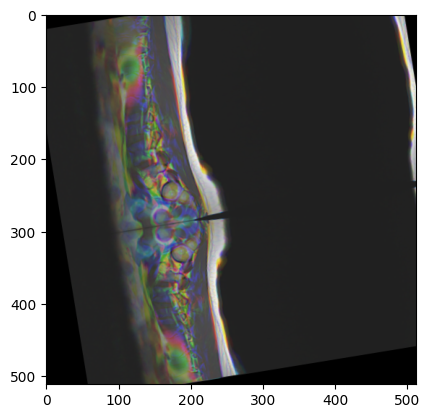

y stat: (512, 512, 3) 0.0 0.96470594 0.19110608 0.1515823

x stat: torch.Size([1, 30, 512, 512]) tensor(-1.) tensor(0.9922) tensor(-0.6914) tensor(0.3289)
tensor([[0, 0, 1, 2, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 2, 0, 0, 1, 1, 1,
         0]]) torch.Size([1, 25])


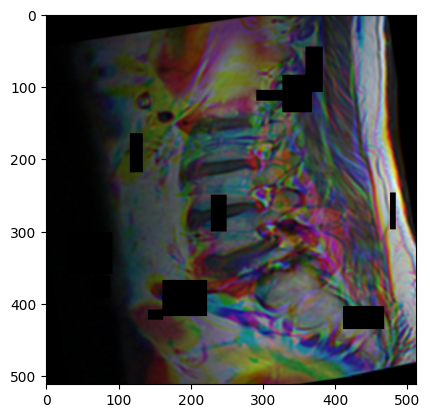

y stat: (512, 512, 3) 0.0 0.99215686 0.21368925 0.18514155



In [13]:
tmp_ds = RSNA24Dataset(df, phase='train', transform=transforms_train)
tmp_dl = DataLoader(
            tmp_ds,
            batch_size=1,
            shuffle=False,
            pin_memory=True,
            drop_last=False,
            num_workers=0
            )

for i, (x, t) in enumerate(tmp_dl):
    if i==2:break
    print('x stat:', x.shape, x.min(), x.max(),x.mean(), x.std())
    print(t, t.shape)
    y = x.numpy().transpose(0,2,3,1)[0,...,:3]
    y = (y + 1) / 2
    plt.imshow(y)
    plt.show()
    print('y stat:', y.shape, y.min(), y.max(),y.mean(), y.std())
    print()
plt.close()
del tmp_ds, tmp_dl

# Define Model
We use timm, which is commonly used for image classification.

In [14]:
class RSNA24Model(nn.Module):
    def __init__(self, model_name, in_c=30, n_classes=75, pretrained=True, features_only=False):
        super().__init__()
        self.model = timm.create_model(
                                    model_name,
                                    pretrained=pretrained, 
                                    features_only=features_only,
                                    in_chans=in_c,
                                    num_classes=n_classes,
                                    global_pool='avg'
                                    )
    
    def forward(self, x):
        y = self.model(x)
        return y

# Testing Model
Checking if the model works properly.

In [15]:
m = RSNA24Model(MODEL_NAME, in_c=IN_CHANS, n_classes=N_CLASSES, pretrained=False)
i = torch.randn(2, IN_CHANS, 512, 512)
out = m(i)
for o in out:
    print(o.shape, o.min(), o.max())

torch.Size([75]) tensor(-0.5333, grad_fn=<MinBackward1>) tensor(0.5251, grad_fn=<MaxBackward1>)
torch.Size([75]) tensor(-0.5200, grad_fn=<MinBackward1>) tensor(0.5256, grad_fn=<MaxBackward1>)


In [16]:
del m, i, out

# Train loop

In [ ]:
%time
#autocast = torch.cuda.amp.autocast(enabled=USE_AMP, dtype=torch.bfloat16) # if your gpu is newer Ampere, you can use this, lesser appearance of nan than half
autocast = torch.cuda.amp.autocast(enabled=USE_AMP, dtype=torch.half) # you can use with T4 gpu. or newer
scaler = torch.cuda.amp.GradScaler(enabled=USE_AMP, init_scale=4096)

val_losses = []
train_losses = []
skf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=SEED)
for fold, (trn_idx, val_idx) in enumerate(skf.split(range(len(df)))):
    #if NOT_DEBUG == False:
    if fold not in SELECTED_FOLDS: 
        print(f"Jump fold {fold}")
        continue;
    else:
        print('#'*30)
        print(f'Start fold {fold}')
        print('#'*30)
        print(len(trn_idx), len(val_idx))
        df_train = df.iloc[trn_idx]
        df_valid = df.iloc[val_idx]

        train_ds = RSNA24Dataset(df_train, phase='train', transform=transforms_train)
        train_dl = DataLoader(
                    train_ds,
                    batch_size=BATCH_SIZE,
                    shuffle=True,
                    pin_memory=True,
                    drop_last=True,
                    num_workers=N_WORKERS
                    )

        valid_ds = RSNA24Dataset(df_valid, phase='valid', transform=transforms_val)
        valid_dl = DataLoader(
                    valid_ds,
                    batch_size=BATCH_SIZE*2,
                    shuffle=False,
                    pin_memory=True,
                    drop_last=False,
                    num_workers=N_WORKERS
                    )

        model = RSNA24Model(MODEL_NAME, IN_CHANS, N_CLASSES, pretrained=True)
        fname = f'{OUTPUT_DIR}/best_wll_model_fold-{fold}.pt'
        if os.path.exists(fname):
            model = RSNA24Model(MODEL_NAME, IN_CHANS, N_CLASSES, pretrained=False)
            model.load_state_dict(torch.load(fname))
        model.to(device)

        optimizer = AdamW(model.parameters(), lr=LR, weight_decay=WD)

        warmup_steps = EPOCHS/10 * len(train_dl) // GRAD_ACC
        num_total_steps = EPOCHS * len(train_dl) // GRAD_ACC
        num_cycles = 0.475
        scheduler = get_cosine_schedule_with_warmup(optimizer,
                                                    num_warmup_steps=warmup_steps,
                                                    num_training_steps=num_total_steps,
                                                    num_cycles=num_cycles)

        weights = torch.tensor([1.0, 2.0, 4.0])
        criterion = nn.CrossEntropyLoss(weight=weights.to(device))

        best_loss = 1.2
        es_step = 0

        for epoch in range(1, EPOCHS+1):
            print(f'start epoch {epoch}')
            model.train()
            total_loss = 0
            with tqdm(train_dl, leave=True) as pbar:
                optimizer.zero_grad()
                for idx, (x, t) in enumerate(pbar):  
                    x = x.to(device)
                    t = t.to(device)

                    with autocast:
                        loss = 0
                        y = model(x)
                        for col in range(N_LABELS):
                            pred = y[:,col*3:col*3+3]
                            gt = t[:,col]
                            loss = loss + criterion(pred, gt) / N_LABELS

                        total_loss += loss.item()
                        if GRAD_ACC > 1:
                            loss = loss / GRAD_ACC

                    if not math.isfinite(loss):
                        print(f"Loss is {loss}, stopping training")
                        sys.exit(1)

                    pbar.set_postfix(
                        OrderedDict(
                            loss=f'{loss.item()*GRAD_ACC:.6f}',
                            lr=f'{optimizer.param_groups[0]["lr"]:.3e}'
                        )
                    )
                    scaler.scale(loss).backward()

                    torch.nn.utils.clip_grad_norm_(model.parameters(), MAX_GRAD_NORM or 1e9)

                    if (idx + 1) % GRAD_ACC == 0:
                        scaler.step(optimizer)
                        scaler.update()
                        optimizer.zero_grad()
                        if scheduler is not None:
                            scheduler.step()                    

            train_loss = total_loss/len(train_dl)
            print(f'train_loss:{train_loss:.6f}')
            train_losses.append(train_loss)
            total_loss = 0

            model.eval()
            with tqdm(valid_dl, leave=True) as pbar:
                with torch.no_grad():
                    for idx, (x, t) in enumerate(pbar):

                        x = x.to(device)
                        t = t.to(device)

                        with autocast:
                            loss = 0
                            loss_ema = 0
                            y = model(x)
                            for col in range(N_LABELS):
                                pred = y[:,col*3:col*3+3]
                                gt = t[:,col]

                                loss = loss + criterion(pred, gt) / N_LABELS
                                y_pred = pred.float()

                            total_loss += loss.item()   

            val_loss = total_loss/len(valid_dl)
            print(f'val_loss:{val_loss:.6f}')
            val_losses.append(val_loss)
            if val_loss < best_loss:

                if device!='cuda:0':
                    model.to('cuda:0')                

                print(f'epoch:{epoch}, best weighted_logloss updated from {best_loss:.6f} to {val_loss:.6f}')
                best_loss = val_loss
                fname = f'{OUTPUT_DIR}/best_wll_model_fold-{fold}.pt'
                torch.save(model.state_dict(), fname)
                print(f'{fname} is saved')
                es_step = 0

                if device!='cuda:0':
                    model.to(device)

            else:
                es_step += 1
                if es_step >= EARLY_STOPPING_EPOCH:
                    print('early stopping')
                    break  
                                

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs
Jump fold 0
##############################
Start fold 1
##############################
1580 395
start epoch 1


100%|██████████| 98/98 [04:57<00:00,  3.03s/it, loss=0.879922, lr=1.959e-04]


train_loss:0.900744


100%|██████████| 13/13 [01:55<00:00,  8.86s/it]


val_loss:0.808402
epoch:1, best weighted_logloss updated from 1.200000 to 0.808402
/kaggle/working/rsna24-results/best_wll_model_fold-1.pt is saved
start epoch 2


 69%|██████▉   | 68/98 [03:19<01:18,  2.60s/it, loss=0.798006, lr=1.975e-04]

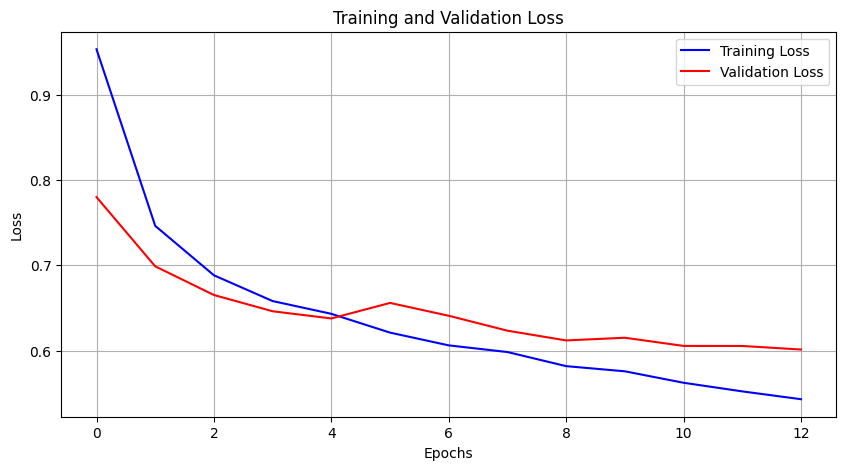

In [19]:
## Plot Losses during training
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='red')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


# 

# Calculation CV

In [20]:
for dirname, _, filenames in os.walk(OUTPUT_DIR):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/working/rsna24-results/best_wll_model_fold-0.pt


In [23]:
cv = 0
y_preds = []
labels = []
weights = torch.tensor([1.0, 2.0, 4.0])
criterion2 = nn.CrossEntropyLoss(weight=weights)

for fold, (trn_idx, val_idx) in enumerate(skf.split(range(len(df)))):
#     if NOT_DEBUG == False:
#         if fold == 1: break;
    if fold not in SELECTED_FOLDS: 
        print(f"Jump fold {fold}")
        continue;
    else:
        print('#'*30)
        print(f'Start fold {fold}')
        print('#'*30)
        df_valid = df.iloc[val_idx]
        valid_ds = RSNA24Dataset(df_valid, phase='valid', transform=transforms_val)
        valid_dl = DataLoader(
                    valid_ds,
                    batch_size=16,
                    shuffle=False,
                    pin_memory=True,
                    drop_last=False,
                    num_workers=N_WORKERS
                    )

        model = RSNA24Model(MODEL_NAME, IN_CHANS, N_CLASSES, pretrained=False)
        fname = f'{OUTPUT_DIR}/best_wll_model_fold-{fold}.pt'
        model.load_state_dict(torch.load(fname))
        model.to(device)   

        model.eval()
        with tqdm(valid_dl, leave=True) as pbar:
            with torch.no_grad():
                for idx, (x, t) in enumerate(pbar):

                    x = x.to(device)
                    t = t.to(device)

                    with autocast:
                        y = model(x)
                        for col in range(N_LABELS):
                            pred = y[:,col*3:col*3+3]
                            gt = t[:,col] 
                            y_pred = pred.float()
                            y_preds.append(y_pred.cpu())
                            labels.append(gt.cpu())

    y_preds = torch.cat(y_preds)
    labels = torch.cat(labels)

##############################
start fold0
##############################


100%|██████████| 25/25 [00:36<00:00,  1.46s/it]


In [24]:
cv = criterion2(y_preds, labels)
print('cv score:', cv.item())

cv score: 0.6487987041473389


# Calculation Competition Metrics
This will give a slightly different score, probably due to the different behavior for nan.

In [25]:
from sklearn.metrics import log_loss
y_pred_np = y_preds.softmax(1).numpy()
labels_np = labels.numpy()
y_pred_nan = np.zeros((y_preds.shape[0], 1))
y_pred2 = np.concatenate([y_pred_nan, y_pred_np],axis=1)
weights = []
for l in labels:
    if l==0: weights.append(1)
    elif l==1: weights.append(2)
    elif l==2: weights.append(4)
    else: weights.append(0)
cv2 = log_loss(labels, y_pred2, normalize=True, sample_weight=weights)
print('cv score:', cv2)

cv score: 0.648798753343581


In [26]:
np.save(f'{OUTPUT_DIR}/labels.npy', labels_np)
np.save(f'{OUTPUT_DIR}/final_oof.npy', y_pred2)

# When predictions are random
gets around 1.1.

In [ ]:
random_pred = np.ones((y_preds.shape[0], 3)) / 3.0
y_pred3 = np.concatenate([y_pred_nan, random_pred],axis=1)
cv3 = log_loss(labels, y_pred3, normalize=True, sample_weight=weights)
print('random score:', cv3)

In [ ]:
# !rm -r cvt_png

# Continuing with the [Submission Baseline...](https://www.kaggle.com/code/itsuki9180/rsna2024-lsdc-submission-baseline)